#<center> <b>Graph Neural Networks</b> </center>
### <center>Hands on session on predicting molecule constrained solubility using ZINC (12k) dataset</center>

##### <center> Prepared by Michael Bronstein, Eduardo Castro, Diogo Pernes and Ana Rebelo </center>


# Setup

We start by:
* installing some packages which will be needed in this tutorial;
* importing all the libraries required through the tutorial.

In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 9.3MB/s 
     |████████████████████████████████| 1.4MB 7.4MB/s 
     |████████████████████████████████| 225kB 7.7MB/s 
     |████████████████████████████████| 235kB 12.5MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 


In [ ]:
%matplotlib inline
import os
import glob
import re
import types
import matplotlib.pyplot as plt

import numpy as np
import networkx as nx

import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import DataLoader
from torch_scatter import scatter_mean

# Downloading the Data

For this tutorial we will focus on a **graph regression problem**, using the ZINC dataset (12k split).
This split has 12k molecules along with a molecular property known as the constrained solubility, the value we want to regress.
More information about the dataset can be found [here](https://arxiv.org/pdf/2003.00982.pdf). To download the data we will use the **pytorch_geometric** library.

In [ ]:
root = ""
# download the dataset
train_dataset = torch_geometric.datasets.ZINC(root, subset=True, split='train', transform=None, pre_transform=None, pre_filter=None)
val_dataset = torch_geometric.datasets.ZINC(root, subset=True, split='val', transform=None, pre_transform=None, pre_filter=None)
test_dataset = torch_geometric.datasets.ZINC(root, subset=True, split='test', transform=None, pre_transform=None, pre_filter=None)

print("Dataset length (train): ", len(train_dataset))
print("Dataset length (val):   ", len(val_dataset))
print("Dataset length (test):  ", len(test_dataset))

Extracting ./molecules.zip
Processing...


Processing test dataset: 100%|██████████| 1000/1000 [00:00<00:00, 20112.51it/s]

Done!
Dataset length (train):  10000
Dataset length (val):    1000
Dataset length (test):   1000


# Data Visualization

We start by visualizing the data.
We define the following functions:

``` 
draw_molecule(graph)
    displays the molecule structure as graph where node color indicates the atom and edge width the type of bond;

plot_atom_count(dataset)
    displays the count for each atom type in the dataset;

plot_bond_count(dataset)
    displays the count for each chemical bond type in the dataset;

plot_solubilities(dataset)
    displays an histogram of the solubilities of the molecules in the ZINC dataset.

```



In [ ]:
def draw_molecule(graph, cmap="Set1", vmin=None, vmax=None, layout=nx.kamada_kawai_layout):
    mol = to_networkx(graph)
    node_labels = graph.x[list(mol.nodes)].numpy()
    plt.figure(1, figsize=(4,4)) 
    nx.draw(mol, pos=layout(mol), cmap=plt.get_cmap(cmap),
            node_color=node_labels, node_size=75, linewidths=6, width=graph.edge_attr.numpy(),
            vmin=None, vmax=None)
    plt.show()

def plot_atom_count(dataset):
    element_count = np.concatenate([data.x for data in dataset])
    (unique, counts) = np.unique(element_count, return_counts=True)
    plt.bar(unique, counts)
    plt.title("Elements in the dataset")
    plt.show()

def plot_bond_count(dataset):
    bond_count = np.concatenate([data.edge_attr for data in dataset])
    (unique, counts) = np.unique(bond_count, return_counts=True)
    plt.bar(unique, counts)
    plt.title("Bonds in the dataset")
    plt.show()
   
def plot_solubilities(dataset):
    solubilities = np.concatenate([data.y for data in dataset])
    x, bins = np.histogram(solubilities, bins=100)
    plt.hist(x, bins)
    plt.title("Solubilities")
    plt.show()


Molecule vizualization


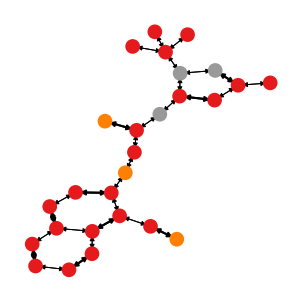

Atom Counts


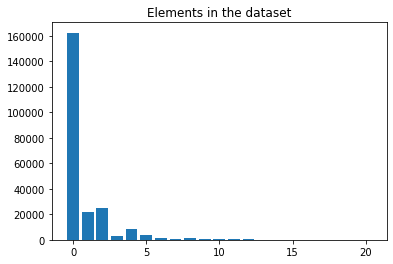

Bond Counts


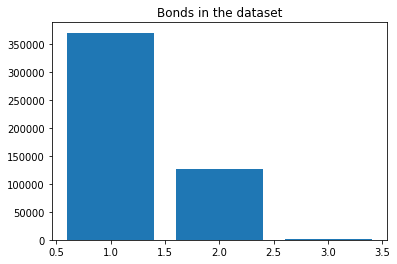

Solubilities


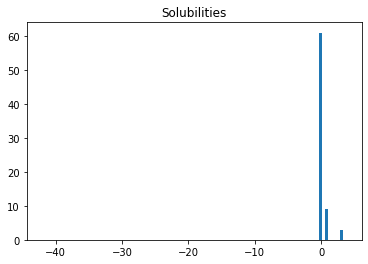

In [ ]:
print("Molecule vizualization")
index = 20
molecule = train_dataset[index]
draw_molecule(molecule)

print("Atom Counts")
plot_atom_count(train_dataset)

print("Bond Counts")
plot_bond_count(train_dataset)

print("Solubilities")
plot_solubilities(train_dataset)

<h3> Quick overview of the values in the dataset </h3>

We can see that there are 21 atom types: {0, ..., 20}

We can see that there are 3 bond types: {1, 2, 3}

The chemical property we are trying to predict is in the range: [-42.0366, 3.8048], although most examples for the water solubility appear near $0$.

In [ ]:
interval = lambda s: (min(s), max(s))
print(interval(np.concatenate([data.x for data in train_dataset])))
print(interval(np.concatenate([data.edge_attr for data in train_dataset])))
print(interval([data.y for data in train_dataset]))


(array([0]), array([20]))
(1, 3)
(tensor([-42.0366]), tensor([3.8048]))


# <center><b> Learning to predict Constrained Solubility with Graph Neural Networks </center></b>

We will now go over to the typical models we may use to solve this task and how to enhance them for this specific task.


## **Graph Convolutional Networks (GCN)**
Our model will be composed of:
* Four Convolutional Layers (GCN)
* Readout Layer (mean)
* Multilayer Perceptron

---

### Convolution Operation
The simplest form of GNNs are Graph Convolutional Networks. These models define a convolution operation on a graph which works by:
 * Linearly transforming the node features;
 * Propagating the node features to their neighboorhod using the normalized adjacency matrix;

$$\mathbf{H^{(l+1)}} = \sigma (\mathbf{W^lH^lA^*} + \mathbf{b})$$

This convolution operation can be repeated over and over to create deep neural networks. Similarly to other models, a bias term and an activation function are applied after the convolution operation. Residual connections and Batch normalization may also be used.

---

### Readout layer
After applying multiple convolutional layers to the model, node features need to be aggregated to obtain a molecule-level representation. For this we will simply use the mean of all node representations at the last convolutional layer.
$$\mathbf{H^{molecule}} = \frac{1}{|V|}\sum_{n \in V} \mathbf{H^L} $$

---

### Multilayer Perceptron

An MLP will be used to regress the constrained water solubility based on the molecule representation.

### Implementation

We will need the following blocks:
``` 
one_hot_encode(x)
    A model which converts categorical to one hot encoded features;

readout_mean(H)
    Maps a set of node representations-> one molecule representation;

ConvLayer(H, A_norm)
    Performs graph convolution as described;

MLP(H)
    Simple multilayer perceptron

GCNModel(data)
    The whole model
```

In [ ]:
def one_hot_encode(x, n_cat=21, sub1=False):
    if sub1:
      x=x-1
    return F.one_hot(torch.squeeze(x), n_cat).to(torch.float32)

def readout_mean(H, batch=None):
    if batch is not None:
        return scatter_mean(H, batch, dim=0)
    else:
        return torch.mean(H, 0)

def get_MLP(feat_in, hidden_feat):
    return torch.nn.Sequential(torch.nn.Linear(feat_in, hidden_feat), torch.nn.LeakyReLU(),
                               torch.nn.Linear(hidden_feat, hidden_feat), torch.nn.LeakyReLU(),
                               torch.nn.Linear(hidden_feat, 1))

def normalize_adj(A):
    D_ = torch.sum(A, axis=0).pow(-0.5)
    A_norm = torch.einsum("j,jk,k->jk", D_, A, D_)
    return A_norm

def get_normalized_adj_matrix(data):
    n = len(data.x)
    x, y = data.edge_index
    # self loops included with eye
    A = torch.eye(n)
    A[x, y] = 1
    return normalize_adj(A).to(data.edge_index.device)

class ConvLayer(torch.nn.Module):
    def __init__(self, feat_in, feat_out):
        super(ConvLayer, self).__init__()
        self.W = torch.nn.parameter.Parameter(torch.FloatTensor(feat_in, feat_out))
        self.b = torch.nn.parameter.Parameter(torch.FloatTensor(feat_out))
        self.reset_parameters()
      
    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.W)
        torch.nn.init.zeros_(self.b)

    def forward(self, H, A_norm):
        WH = torch.matmul(H, self.W)
        WHA = torch.spmm(A_norm, WH)
        return WHA + self.b

class GCN_block(torch.nn.Module):
    def __init__(self, feat_in, feat_out, residual=True):
        super(GCN_block, self).__init__()
        self.conv = ConvLayer(feat_in, feat_out)
        self.bn = torch.nn.BatchNorm1d(feat_out)
        self.relu = torch.nn.ReLU()
        self.residual = residual

    def forward(self, H, A_norm):
        if self.residual:
            return self.relu(self.bn(self.conv(H, A_norm))) + H
        else:
            return self.relu(self.bn(self.conv(H, A_norm)))

class GCN_model(torch.nn.Module):
    def __init__(self, feat_in, feat_hidden=128, n_layers=4):
        super(GCN_model, self).__init__()
        self.layers = torch.nn.ModuleList([GCN_block(feat_in if i==0 else feat_hidden,
                                                     feat_hidden,
                                                     residual=False if i==0 else True) for i in range(n_layers)])
        self.mlp = get_MLP(feat_hidden, feat_hidden)
      
    def forward(self, data):
        A_norm = get_normalized_adj_matrix(data)
        H = one_hot_encode(data.x)
        for l in self.layers:
            H = l(H, A_norm)
        if type(data)==torch_geometric.data.batch.Batch:
            H = readout_mean(H, data.batch)
        else:
            H = readout_mean(H)
        out = torch.squeeze(self.mlp(H))
        return out

### Mini-batching for graph neural networks

The previously implemented forward method for the **GCN_model** expects a single graph as input. However, similarly to other deep learning models we want to do gradient descend on mini-batches. In graphs this can be achived by creating a large graph which contains all the graphs in the batch:

$$ \begin{split}\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \qquad 
\mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \qquad 
\mathbf{y} = \begin{bmatrix} y_1 \\ \vdots \\ y_n \end{bmatrix}\end{split} $$

**pytorch_geometric** already takes care of this for us (more on this [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#mini-batches)), except for the readout layer in which we implemented two versions, one for an individual example and one for a batch. We can now go ahead and verify that our model is working as intended. For this we swith to **eval** (batch normalization) mode and evaluate a sample inside a batch or individually, and verify they have the same result.

In [ ]:
model = GCN_model(21)
model.eval()
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
for data in train_loader:
  break
print(model(data)[0])
print(model(data[0]))

tensor(0.0377, grad_fn=<SelectBackward>)
tensor(0.0377, grad_fn=<SqueezeBackward0>)


### Model Training and Evaluation

Here we provide a generic script to train models.
These are generic loops as used in other deep learning models.

In [ ]:
def train(model, train_loader, val_loader, optimizer, scheduler, n_epochs, best_model_path):
  history = {"train_mae": list(),
             "val_mae": list()}
  best_valid_mae = float("inf")

  for epoch in range(1, n_epochs+1):
    model.train()
    train_mae = 0
    n = 0
    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model(data)
      loss = F.l1_loss(out, data.y)
      loss.backward()
      optimizer.step()
      train_mae += loss.detach().cpu().numpy() * data.num_graphs
      n += data.num_graphs
    train_mae /= n
    history["train_mae"].append(train_mae)

    model.eval()
    val_mae = 0
    n = 0
    for data in val_loader:
      data = data.to(device)
      out = model(data)
      loss = F.l1_loss(out, data.y)
      val_mae += loss.detach().cpu().numpy() * data.num_graphs
      n += data.num_graphs
    val_mae /= n
    history["val_mae"].append(val_mae)
    scheduler.step(val_mae)
    if val_mae<best_valid_mae:
      torch.save(model.state_dict(), best_model_path)
    print(f"Epoch {epoch} - train_mae: {history['train_mae'][-1]}, val_mae: {history['val_mae'][-1]}")

  return history

def test(model, test_loader):
  model.eval()
  test_mae = 0
  n = 0
  for data in test_loader:
    data = data.to(device)
    out = model(data)
    loss = F.l1_loss(out, data.y)
    test_mae += loss.detach().cpu().numpy() * data.num_graphs
    n += data.num_graphs
  test_mae /= n
  return test_mae



Now with the implemented functions we can optimize our model and evaluate how it performs in the task of predicting contrained solubility.

Epoch 1 - train_mae: 0.7571004023075104, val_mae: 0.5921204264163971
Epoch 2 - train_mae: 0.637338877248764, val_mae: 0.6319715247154236
Epoch 3 - train_mae: 0.619238474559784, val_mae: 0.6327597482204437
Epoch 4 - train_mae: 0.5944418216705323, val_mae: 0.7039905409812928
Epoch 5 - train_mae: 0.5898118112564087, val_mae: 0.6100518822669982
Epoch 6 - train_mae: 0.5913573287963867, val_mae: 0.7814737048149109
Epoch 7 - train_mae: 0.5915236787319184, val_mae: 0.55534122133255
Epoch 8 - train_mae: 0.5733357036590576, val_mae: 0.5979315912723542
Epoch 9 - train_mae: 0.5570550949573517, val_mae: 0.5514420564174652
Epoch 10 - train_mae: 0.5548901873111725, val_mae: 0.8021526985168457
Epoch 11 - train_mae: 0.5481652178764344, val_mae: 0.6868929147720337
Epoch 12 - train_mae: 0.5527676518440247, val_mae: 0.6497131695747376
Epoch 13 - train_mae: 0.5514426865577697, val_mae: 0.5185519711971283
Epoch 14 - train_mae: 0.5393642329216003, val_mae: 0.5520522115230561
Epoch 15 - train_mae: 0.539863348

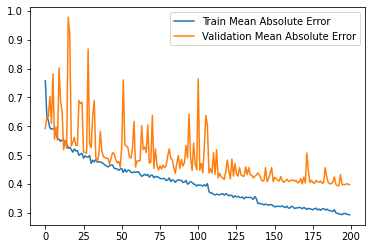

In [ ]:
best_model_path = "GCN.pth"
n_epochs = 200

# Data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min",
                                                       factor=0.5, patience=20,
                                                       verbose=True)

# Training
history = train(model, train_loader, val_loader, optimizer, scheduler, n_epochs, best_model_path)

# Display results
plt.plot(history["train_mae"], label="Train Mean Absolute Error")
plt.plot(history["val_mae"], label="Validation Mean Absolute Error")
plt.legend()
plt.show()

In [ ]:
model_path = "GCN.pth"

# Evaluation
model.load_state_dict(torch.load(model_path))
test_mae = test(model, test_loader)
print("Test Mean Absolute Error", test_mae)

Test Mean Absolute Error 0.39500309705734254


### Message Passing Visualization

Before we move on to the next family of models, in a final experiment we visualize how messages are propagated throughout the neural network. For this we set one node to 1 and all others to 0. We then perform the convolution operation multiple times with a kernel where $\mathbf{W}=\mathbf{1}$ and $\mathbf{b}=\mathbf{0}$. In this way, the only "source of information" is this node, and values different than zero in other nodes indicate that information has reached from the initial node.


Notice that, with the convolution operation, the propagation of the node features to their neighboors happens due to the multiplication of the adjacency matrix with the node features. We can see that, for distant nodes, communication is difficult. Even after several layers, the most distant nodes are only slightly influenced by the value of the central node.


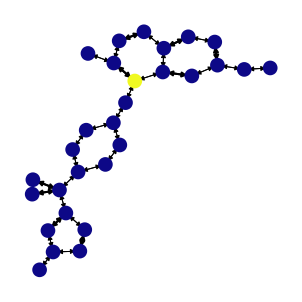

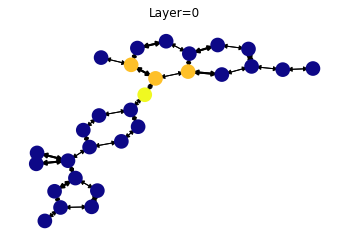

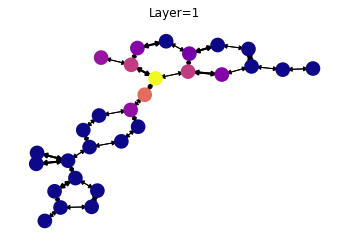

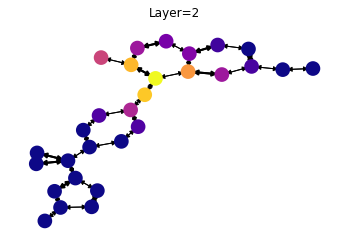

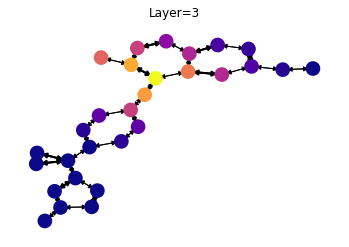

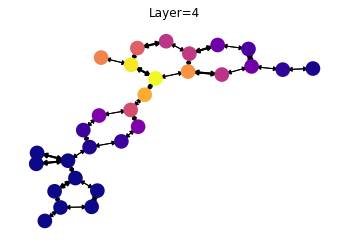

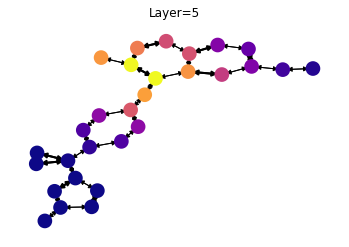

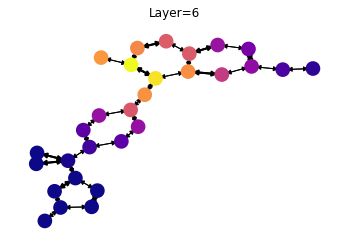

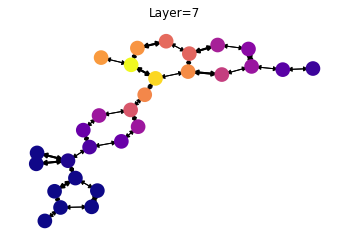

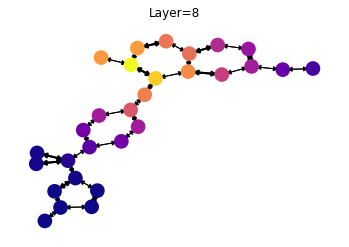

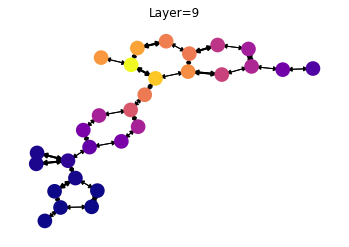

In [ ]:
model = GCN_model(21)

index_example = 0
vertex_idx = 10
n_layers = 10

data = train_dataset[index_example]
data.x = torch.zeros((len(data.x), 1))
data.x[vertex_idx] = 1
h = data.x
A_norm = get_normalized_adj_matrix(data)

draw_molecule(data, cmap="plasma", vmin=0, vmax=1)

conv = ConvLayer(1, 1)
torch.nn.init.ones_(conv.W)
torch.nn.init.zeros_(conv.b)

for i in range(n_layers):
  with torch.no_grad():
    data.x = conv(data.x, A_norm)
    plt.title(f"Layer={i}")
    draw_molecule(data, cmap="plasma")

## **Message Passing Neural Networks (MPNN's)**

In Gilmer et al.'s [Neural message passing for Quantum chemistry](https://arxiv.org/pdf/1704.01212.pdf) (2017),
authors propose a unifying framework for graph neural networks, which includes the above GCN. This framework states that each model is composed of two operations:
* Message Passing
* Readout Phase

Using this framework to analyse the previous model, the message passing corresponds to agregating the neighboors information using the convolutional layer and the readout phase is a simple mean of all the feature vectors of the nodes. 

---
## Message Passing
"During the message passing phase, hidden states $h^{(t)}_v$ at each node in the graph are updated based on messages $m^{(t+1)}_v$ according to":

$$m^{(t+1)}_v = \sum_{w\in \mathcal{N}(v)} M_t (h^{(t)}_v, h^{(t)}_w, e_{vw})$$

$$h^{(t+1)}_v = U_t (h^{(t)}_v, m^{(t+1)}_v)$$

## Readout Phase
The readout phase aggregates all the nodes information into a single feature vector.

$$ \hat{y} = R (\{h^{(T)}_v| v \in G\})$$

---

The model we will implement next allows for edge features to be used in the computation. For this $M_t$ will take the form of $M_t(h^{(t)}_v, h^{(t)}_w, e_{vw}) = A(e_{vw}) h^{(t)}_w$, where $A$ is a neural network. In other words, the neighboors features will be modulated by the type of edge (chemical bond) that connects them. Conveniently, pytorch geometric already has a MessagePassing base class which does most of the heavy lifting for us.




### Implementation

In pytorch geometric, the message passing implementation follows the framework shown:

$$h^{(t+1)}_v = U_t (h^{(t)}_v, \square_{w\in \mathcal{N}(v)} M_t (h^{(t)}_v, h^{(t)}_w, e_{vw})) $$

where:
 * $M_t$ denotes the **message** function
 * $\square$ denotes the aggregation function choosen (add, mean, max)
 * $U_t$ denotes the **update** function


The implementation shown below for the ```MPNN_Conv``` is partially based on the pytorch_geometric [NNConv](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/nn_conv.html#NNConv).

Note that **propagate** calls **message, aggregate,** and **update**, sequentially.

A few notes on this model:
  * no residual connection (GRU unit is already there);
  * no batch normalization;
  * weight tying accross all layers of the network.

In [ ]:
from torch_scatter import scatter_mean
from torch_geometric.nn import BatchNorm
from torch_geometric.nn.conv import MessagePassing

class MPNN_Conv(MessagePassing):
    def __init__(self, in_channels, nnet, aggr='add'):
        super(MPNN_Conv, self).__init__(aggr=aggr)
        self.nnet = nnet

        self.gru_unit = torch.nn.GRUCell(in_channels, in_channels)
        self.in_channels_l = in_channels

    def forward(self, h, edge_index, edge_attr):
        return self.propagate(edge_index, h=h, edge_attr=edge_attr)

    def message(self, h_j, edge_attr):
        weight = self.nnet(edge_attr)
        weight = weight.view(-1, self.in_channels_l, self.in_channels_l)
        return torch.matmul(h_j.unsqueeze(1), weight).squeeze(1)
    
    def update(self, aggr_out, h):
        return F.relu(self.gru_unit(aggr_out, h))

class MPNN_model(torch.nn.Module):
    def __init__(self, feat_in, nnet, aggr, feat_hidden=128, T=4):
        super(MPNN_model, self).__init__()
        self.T = T
        self.layer = MPNN_Conv(feat_hidden, nnet=nnet, aggr=aggr)

        self.mlp = get_MLP(feat_hidden, feat_hidden)
        self.h_embedding = torch.nn.Embedding(feat_in, feat_hidden)
      
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        h = torch.squeeze(self.h_embedding(x))
        edge_attr = one_hot_encode(edge_attr, 3, sub1=True)
        for _ in range(self.T):
            h = self.layer(h, edge_index, edge_attr)
        if type(data)==torch_geometric.data.batch.Batch:
            h = readout_mean(h, data.batch)
        else:
            h = readout_mean(h)
        out = torch.squeeze(self.mlp(h))
        return out

def edge_net(feat_in, mpnn_features):
  return torch.nn.Sequential(torch.nn.Linear(feat_in, feat_in),
                             torch.nn.ReLU(),
                             torch.nn.Linear(feat_in, mpnn_features * mpnn_features),
                            )



```
# This is formatted as code
```

### Different Aggregation Functions

We may reuse the train and test functions defined before.

Different aggregation functions may yield different results depending on the task that you are trying to solve. We can evaluate functions by changing the aggr argument in our implementation of the MPNN_model. Use the code below to evaluate which aggregation function is best.

Epoch 1 - train_mae: 0.8576124497413635, val_mae: 0.6364365181922913
Epoch 2 - train_mae: 0.5960135858535767, val_mae: 0.6069414966106415
Epoch 3 - train_mae: 0.5509266342163086, val_mae: 0.7565835676193238
Epoch 4 - train_mae: 0.5339579343795776, val_mae: 0.5299660582542419
Epoch 5 - train_mae: 0.4871380834579468, val_mae: 0.6669158983230591
Epoch 6 - train_mae: 0.502466820526123, val_mae: 0.5136354901790618
Epoch 7 - train_mae: 0.4720512243747711, val_mae: 0.4983959891796112
Epoch 8 - train_mae: 0.4525078421115875, val_mae: 0.4661620717048645
Epoch 9 - train_mae: 0.4517619166135788, val_mae: 0.4515268349647522
Epoch 10 - train_mae: 0.43607025237083435, val_mae: 0.4537735908031464
Epoch 11 - train_mae: 0.4317121842384338, val_mae: 0.4245375125408173
Epoch 12 - train_mae: 0.4272980899810791, val_mae: 0.426975759267807
Epoch 13 - train_mae: 0.4103328315973282, val_mae: 0.4087750585079193
Epoch 14 - train_mae: 0.40974409828186037, val_mae: 0.424939001083374
Epoch 15 - train_mae: 0.411615

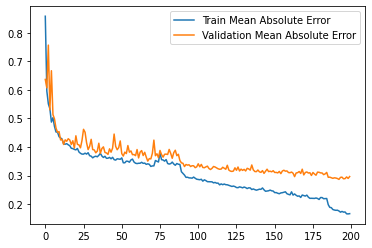

In [ ]:
# change the aggr function and understand how your model is doing
aggr = "add"  # max, mean, add

best_model_path = f"MPNN_{aggr}.pth"
n_epochs = 200

# Data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPNN_model(21, edge_net(3, 128), aggr)
model = model.to(device)

# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min",
                                                       factor=0.5, patience=20,
                                                       verbose=True)

# Training
history = train(model, train_loader, val_loader, optimizer, scheduler, n_epochs, best_model_path)

# Display results
plt.plot(history["train_mae"], label="Train Mean Absolute Error")
plt.plot(history["val_mae"], label="Validation Mean Absolute Error")
plt.legend()
plt.show()


In [ ]:
# Evaluation
model_paths = ["MPNN_add.pth", "MPNN_mean.pth", "MPNN_max.pth"]
aggrs = ["add", "mean", "max"]

for aggr, model_path in zip(aggrs, model_paths):
  try:
    model = MPNN_model(21, edge_net(3, 128), aggr)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
  except:
    continue
  test_mae = test(model, test_loader)
  print(model_path, "Test Mean Absolute Error", test_mae)

MPNN_add.pth Test Mean Absolute Error 0.29674241971969606
MPNN_mean.pth Test Mean Absolute Error 0.34673185634613035
MPNN_max.pth Test Mean Absolute Error 0.337041588306427


# Improving Graph Neural Networks by Structural Encoding in the Node Features

For a complete view of the topic of this section, please read the Bouritsas et al.'s [Improving Graph Neural Network Expressivity Via Subgraph Isomorphism Couting](https://arxiv.org/pdf/2006.09252.pdf) (2020).

We now proceed in improving the current MPNN model by incorporating structural encoding in the node features. Within a graph there are typical substructures such as cycles, cliques and paths. These substructures confere the nodes that compose it a structural role. For instance, a node may be at the end of a path or in the middle. However, graph neural networks are agnostic to these structural roles of nodes.

### Motivation for molecular chemistry
In molecular chemistry, different parts of the molecule may have different functions. For instance, functional groups are known to be responsable for certain properties, regardless of the other atoms present in the molecule. As such, chemical bonds that appear within a known functional group should be treated differently than bonds which appear on other regions which may be uninteresting to chemical property prediction.

### Structural encoding

In this work, for each node we will count the number of cycles of length $k$ in which it is inserted. Then we will append this information to the node representation at the input of the model. Our new node representation will take the form of:
$$\hat{h}_v^0 = (h_v^0, c_v^{(3)}, c_v^{(4)}, c_v^{(5)}, c_v^{(6)})$$

where $c_v^{(k)}$ is the number of cycles of length $k$ that node $v$ is part of.

### Couting cycles in a graph

We use the **cycle_basis** function from the **networkx** python package to find the cycles in a graph.

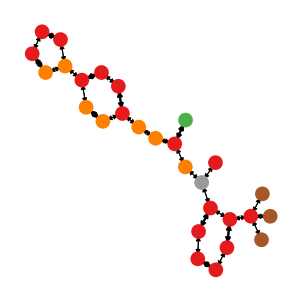

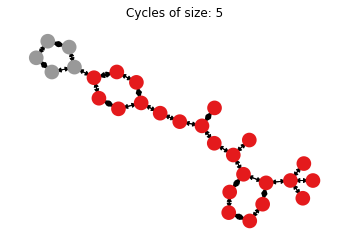

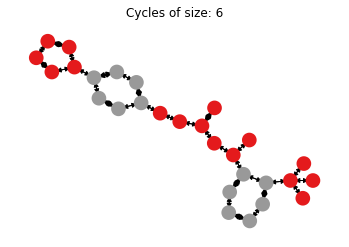

In [ ]:
# obtain a training example from the dataset
index_example = 5
data = train_dataset[index_example]
draw_molecule(data)

# count the number of cycles
graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
cycles = nx.algorithms.cycles.cycle_basis(graph)
feats = torch.zeros(len(data.x), 4)

# encoding
for cycle in cycles:
  l = len(cycle)
  if l>2 and l<7:
    for v in cycle:
      feats[v, l-3] += 1

# vizualization
for i, k in enumerate([3, 4, 5, 6]):
    if sum(feats[:, i]) == 0:
      continue
    plt.title(f"Cycles of size: {k}")
    data.x = feats[:, i]
    draw_molecule(data)

Now that we have verifyed that the model is working as intended we can go ahead and define a new model which uses this information. We will follow the same structure of the MPNN model but we will append this features to the node representations. Notice that these new features are not categorical, and so should not be passed to the embedding layer.

``` 
append_structure(data)
    Add a new property to the graph with the number of counts for each cycle, for each node.

MPNN_model_with_Cycle_Embedding(data)
    A new model which receives a graph containing the node structural encoding as well.
```


In [ ]:
def append_structure(data, low=3, high=6):
    n = len(data.x)
    feats = torch.zeros(n, high-low+1)
    graph = torch_geometric.utils.to_networkx(data, to_undirected=True)
    cycles = nx.algorithms.cycles.cycle_basis(graph)
    for cycle in cycles:
      l = len(cycle)
      if l>=low and l<=high:
        for v in cycle:
          feats[v, l-low] += 1
    data["str"] = feats
    return data

class MPNN_model_with_Cycle_Embedding(torch.nn.Module):
    def __init__(self, feat_in, nnet, aggr, feat_hidden=128, T=4, str_length=4):
        super(MPNN_model_with_Cycle_Embedding, self).__init__()
        self.T = T
        self.layer = MPNN_Conv(feat_hidden + str_length, nnet=nnet, aggr=aggr)

        self.mlp = get_MLP(feat_hidden + str_length, feat_hidden)
        self.h_embedding = torch.nn.Embedding(feat_in, feat_hidden)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        h = torch.squeeze(self.h_embedding(x))
        h = torch.cat((h, data.str), dim=1)
        edge_attr = one_hot_encode(edge_attr, 3, sub1=True)
        for _ in range(self.T):
            h = self.layer(h, edge_index, edge_attr)
        if type(data)==torch_geometric.data.batch.Batch:
            h = readout_mean(h, data.batch)
        else:
            h = readout_mean(h)
        out = torch.squeeze(self.mlp(h))
        return out

### Model Training and Evaluation


Epoch 1 - train_mae: 0.9062759298324585, val_mae: 0.6958562378883362
Epoch 2 - train_mae: 0.6052842805862427, val_mae: 0.5855389904975891
Epoch 3 - train_mae: 0.5509948583126069, val_mae: 0.5163855402469635
Epoch 4 - train_mae: 0.520392191696167, val_mae: 0.8027631959915161
Epoch 5 - train_mae: 0.4974075168609619, val_mae: 0.506372395992279
Epoch 6 - train_mae: 0.49883328461647036, val_mae: 0.5071248879432678
Epoch 7 - train_mae: 0.4774019887447357, val_mae: 0.4858584008216858
Epoch 8 - train_mae: 0.4670648298025131, val_mae: 0.46750245833396914
Epoch 9 - train_mae: 0.447914396572113, val_mae: 0.44272414231300355
Epoch 10 - train_mae: 0.4391953370094299, val_mae: 0.4297659251689911
Epoch 11 - train_mae: 0.4319941080570221, val_mae: 0.4571064670085907
Epoch 12 - train_mae: 0.41810848588943483, val_mae: 0.5361353414058685
Epoch 13 - train_mae: 0.421971577167511, val_mae: 0.4680387418270111
Epoch 14 - train_mae: 0.41025614738464355, val_mae: 0.42452917075157165
Epoch 15 - train_mae: 0.399

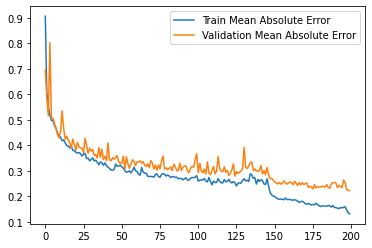

In [ ]:
# change the aggr function and understand how your model is doing
aggr = "add"  # max, mean, add

best_model_path = f"MPNN_with_structural_encoding_{aggr}.pth"
n_epochs = 200

# Data
train_dataset.transform = append_structure
val_dataset.transform = append_structure
test_dataset.transform = append_structure
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MPNN_model_with_Cycle_Embedding(21, edge_net(3, 128+4), aggr)
model = model.to(device)

# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min",
                                                       factor=0.5, patience=20,
                                                       verbose=True)

# Training
history = train(model, train_loader, val_loader, optimizer, scheduler, n_epochs, best_model_path)

# Display results
plt.plot(history["train_mae"], label="Train Mean Absolute Error")
plt.plot(history["val_mae"], label="Validation Mean Absolute Error")
plt.legend()
plt.show()

In [ ]:
# Evaluation
aggr = "add"  # max, mean, add
best_model_path = f"MPNN_with_structural_encoding_{aggr}.pth"
model = MPNN_model_with_Cycle_Embedding(21, edge_net(3, 128+4), aggr)
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)
test_mae = test(model, test_loader)
print("Test Mean Absolute Error", test_mae)

Test Mean Absolute Error 0.1950454763174057


## Comparison with the 1-Weisfeiler-Lehman isomorphism test

It has been proven that standard message passing GNNs cannot distinguish between graphs that are indistinguishable by the 1-WL (Weisfeiler-Lehman) isomorphism test.

E.g., the following two (non-isomorphic) graphs are 1-WL equivalent, thus a standard MPNN will produce the same output for these two graphs:
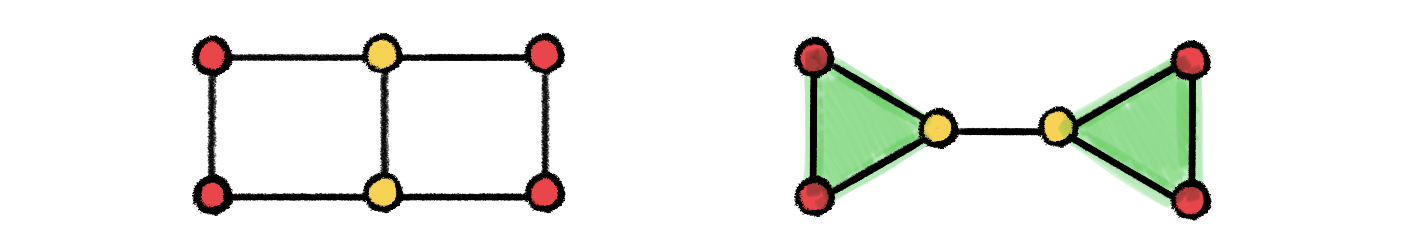

However, if we augment the node features with the structural encoding as we did before, the MPNN will be able to discriminate between them, as we show next.

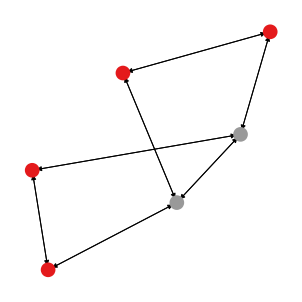

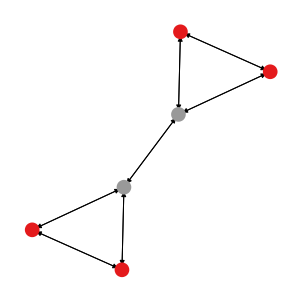

In [ ]:
from torch_geometric.data import Data

# define the two graphs above
g1_edge_index = torch.tensor([[0, 1, 0, 2, 1, 3, 2, 3, 2, 4, 3, 5, 4, 5],
                              [1, 0, 2, 0, 3, 1, 3, 2, 4, 2, 5, 3, 5, 4]], dtype=torch.long)
node_features = torch.tensor([2, 2, 3, 3, 2, 2]).reshape(6, 1)  # here, we use node degrees as node features
edge_features = torch.ones(14, dtype=torch.long)
g1_data = Data(x=node_features, edge_index=g1_edge_index, edge_attr=edge_features)
draw_molecule(g1_data)

g2_edge_index = torch.tensor([[0, 1, 0, 2, 1, 2, 2, 3, 3, 4, 3, 5, 4, 5],
                              [1, 0, 2, 0, 2, 1, 3, 2, 4, 3, 5, 3, 5, 4]], dtype=torch.long)
g2_data = Data(x=node_features, edge_index=g2_edge_index, edge_attr=edge_features)
draw_molecule(g2_data)

In [ ]:
feat_hidden = 16

# vanilla MPNN (i.e. no structural encoding)
mpnn = MPNN_model(4, edge_net(3, feat_hidden), 'add', feat_hidden=feat_hidden, T=4)

# compute the output of the MPNN for the two 1-WL equivalent graphs
with torch.no_grad():
  g1_y = mpnn(g1_data)
  g2_y = mpnn(g2_data)

diff = torch.abs(g1_y - g2_y)
if diff < 1e-6:
  print('The two graphs are indistinguishable (diff = {:.9f})'.format(diff))
else:
  print('The two graphs produced different outputs (diff = {:.9f})'.format(diff))

The two graphs are indistinguishable (diff = 0.000000007)


In [ ]:
# augment the node features by counting the number of cycles with lengths 3 and 4
# that each node appears in
g1_data = append_structure(g1_data, low=3, high=4)
g2_data = append_structure(g2_data, low=3, high=4)

# MPNN with structural encoding
mpnn_str = MPNN_model_with_Cycle_Embedding(4, edge_net(3, feat_hidden+2), 'add', feat_hidden=feat_hidden, T=4, str_length=2)  
with torch.no_grad():
  g1_y = mpnn_str(g1_data)
  g2_y = mpnn_str(g2_data)

diff = torch.abs(g1_y - g2_y)
if diff < 1e-6:
  print('The two graphs are indistinguishable (diff = {:.9f})'.format(diff))
else:
  print('The two graphs produced different outputs (diff = {:.9f})'.format(diff))

The two graphs produced different outputs (diff = 0.028340608)


# Directional Message Passing Neural Networks

This section is based on Beaini et al.'s [Directional Graph Neural Networks](https://arxiv.org/pdf/2010.02863.pdf) (2020).

Message passing GNNs are invariant to the permutation of the neighbours’ features, so the nodes’ received signal is not influenced by swapping the features of two neighbours, which limits their expressive power.

Directional Message Passing Neural Networks use vector fiels in the graph to define directions for the propagation of information. These directions are defined by the __eigenvectors of the Laplacian matrix__, which is defined as:
$$\mathbf{L} = \mathbf{D} - \mathbf{A},$$
where $D$ is the node degree matrix and $A$ is the adjacency matrix of the graph. Indeed, the Laplacian eigenvectors hold such rich information about graph structure that their study is the focus of the mathematical subfield of spectral
graph theory.

This directional information is then used to build aggregation matrices that can either smooth the signal __(low pass filter)__ or compute its derivative __(high pass filter)__ in the specified directions.

The algorithm is summarized as follows.

__Pre-computed steps:__

1 - Given the adjacency matrix $\mathbf{A}$ of a graph with $n$ nodes, compute the corresponding Laplacian matrix $\mathbf{L}$.

2 - Compute and sort the eigenvectors $\boldsymbol{\phi}^{(1)}, \boldsymbol{\phi}^{(2)}, \dots, \boldsymbol{\phi}^{(n)}$ of the Laplacian matrix in increasing order of the respective eigenvalues.

3 - For each of the first $k$ eigenvectors (here, we use $k=2$) whose corresponding eigenvalue is non-zero, compute the corresponding $n \times n$ matrix $\mathbf{F}^{(i)}$ as:

$$\mathbf{F}^{(i)}_{u,v} = \begin{cases} \phi^{(i)}_u - \phi^{(i)}_v, \quad \text{if nodes $u$ and $v$ are connected}, \\
0, \quad \text{otherwise.} \end{cases}$$

4 - Normalize each row of $\mathbf{F}^{(i)}$ so that it has unit $L^1$ norm.

5 - Compute the directional smooting matrices $\mathbf{B}_{av}^{(i)} = |\mathbf{F}^{(i)}|$.

6 - Compute the directional derivative matrices $\mathbf{B}_{dx}^{(i)}$ as:

$$\mathbf{B}_{dx}^{(i)} = \mathbf{F}^{(i)} - \mathrm{diag}\left(\sum_v \mathbf{F}^{(i)}_{:,v}\right).$$

__GNN steps:__

1 - Given the node features $\mathbf{X}^{(t)}$ at the $t$-th layer, perform a standard message passing step as in a vanilla MPNN, obtaining $\mathbf{H}^{(t+1)}$.

2 - Obtain the augmented feature vector $\mathbf{Z}^{(t+1)}$ as:

$$ \mathbf{Z}^{(t+1)} =  \begin{bmatrix}
 \mathbf{D}^{-1}\mathbf{H}^{(t+1)} \\
\mathbf{B}_{av}^{(1)} \mathbf{H}^{(t+1)} \\
|\mathbf{B}_{dx}^{(1)} \mathbf{H}^{(t+1)}| \\
\vdots \\
\mathbf{B}_{av}^{(k)} \mathbf{H}^{(t+1)} \\
|\mathbf{B}_{dx}^{(k)} \mathbf{H}^{(t+1)}|
\end{bmatrix}.$$

3 - Pass $\mathbf{Z}^{(t+1)}$ through an MLP (or recurrent layer) whose output has the same dimension as $\mathbf{X}^{(t)}$, obtaining $\mathbf{X}^{(t+1)}$.



In [ ]:
# function computing matrices B_av and B_dx for a given graph
def get_directional_F(data, k=2, eps=1e-4, get_eig=False):
    n = len(data.x)
    x, y = data.edge_index
    A = torch.zeros((n, n))
    A[x, y] = 1

    L_sparse = torch_geometric.utils.get_laplacian(data.edge_index)
    x, y = L_sparse[0]
    values = L_sparse[1]
    L = torch.zeros((n, n))
    L[x, y] = values

    eig_val, eig_vec = torch.linalg.eig(L)
    eig_val = torch.abs(eig_val.real)  # the eigenvalues of the Laplacian are always real and non-negative 
    eig_vec = eig_vec.real
    indexes = torch.argsort(eig_val)
    eig_vec = eig_vec[:, indexes]
    eig_val = eig_val[indexes]
    eig_vec = eig_vec[:, eig_val>eps][:, 0:k]

    Field = A.unsqueeze(2) * (eig_vec.reshape(n, 1, k) - eig_vec.reshape(1, n, k))
    Field = Field / (torch.sum(torch.abs(Field), dim=1, keepdim=True) + eps)
    Bav = torch.abs(Field)
    Bdx = Field - torch.eye(n).unsqueeze(2) * Field.sum(1, keepdim=True)
    
    x, y = data.edge_index
    data['norm'] = get_normalized_adj_matrix(data)[x, y]
    for i in range(k):
        data['Bav'+str(i)] = Bav[x,y,i]
        data['Bdx'+str(i)] = Bdx[x,y,i]
    
    if get_eig:
      return (data, eig_val, eig_vec)
    else:
      return data

Eigenvector


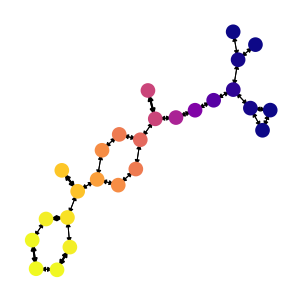


Non-directional message passing


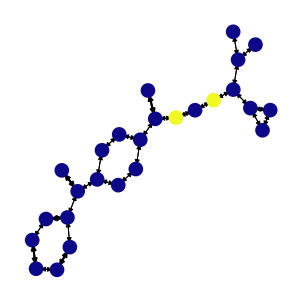


Directional message passing (low pass features)


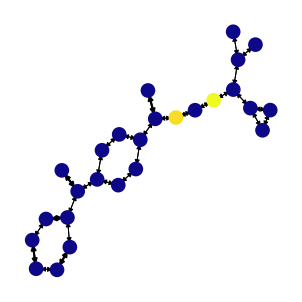


Directional message passing (high pass features)


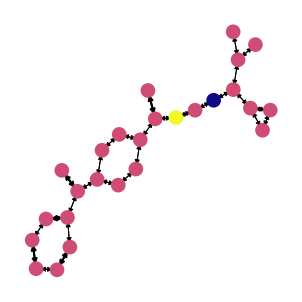

In [ ]:
# Let's visualize an example of the directional features to gain some intuition about the method.

# you can try with different values
example_idx = 1
node_idx = 5

data = train_dataset[example_idx]
data, eig_val, eig_vec = get_directional_F(data, get_eig=True)
n = len(data.x)

# Show the eigenvector projected into the graph nodes
data.x = eig_vec[:, 0]
print("Eigenvector")
draw_molecule(data, cmap="plasma", vmin=0, vmax=1)
print()

# Show the result of non-directional message passing for a given node
data.x = torch.zeros(n, 1)
data.x[node_idx] = 1
x, y = data.edge_index
A = torch.zeros((n, n))
A[x, y] = 1  # adjacency matrix
data.x = A@data.x
print("Non-directional message passing")
draw_molecule(data, cmap="plasma", vmin=0, vmax=1)
print()

# Show the result of directional message passing for the same node
data.x = torch.zeros(n, 1)
data.x[node_idx] = 1
x, y = data.edge_index
Bav0 = torch.zeros((n, n))
Bav0[x, y] = data.Bav0
data.x = Bav0 @ data.x
print("Directional message passing (low pass features)")
draw_molecule(data, cmap="plasma", vmin=0, vmax=1)
print()

data.x = torch.zeros(n, 1)
data.x[node_idx] = 1
x, y = data.edge_index
Bdx0 = torch.zeros((n, n))
Bdx0[x, y] = data.Bdx0
data.x = Bdx0 @ data.x
print("Directional message passing (high pass features)")
draw_molecule(data, cmap="plasma", vmin=0, vmax=1)
print()

In [ ]:
class MPNN_Conv_Dir(MessagePassing):
    def __init__(self, in_channels, nnet, aggr='add'):
        super(MPNN_Conv_Dir, self).__init__(aggr=aggr)
        self.nnet = nnet

        self.gru_unit = torch.nn.GRUCell(in_channels*5, in_channels)
        self.in_channels_l = in_channels

    def forward(self, h, edge_index, edge_attr, norm, bdx0, bdx1, bav0, bav1):
        return self.propagate(edge_index, h=h, edge_attr=edge_attr, norm=norm,
                              bdx0=bdx0, bdx1=bdx1, bav0=bav0, bav1=bav1)

    def message(self, h_j, edge_attr, norm, bdx0, bdx1, bav0, bav1):
        weight = self.nnet(edge_attr)
        weight = weight.view(-1, self.in_channels_l, self.in_channels_l)
        weighted_h_j = torch.matmul(h_j.unsqueeze(1), weight).squeeze(1)

        # concatenate the directional features as explained in the algorithm
        return torch.cat((norm.unsqueeze(1)*weighted_h_j,
                          torch.abs(bdx0.unsqueeze(1)*weighted_h_j),
                          bav0.unsqueeze(1) * weighted_h_j,
                          torch.abs(bdx1.unsqueeze(1)*weighted_h_j),
                          bav1.unsqueeze(1) * weighted_h_j), dim=1)
    
    def update(self, aggr_out, h):
        return F.relu(self.gru_unit(aggr_out, h))

class Directional_MPNN_model(torch.nn.Module):
    def __init__(self, feat_in, nnet, aggr, feat_hidden=128, T=4):
        super(Directional_MPNN_model, self).__init__()
        self.T = T
        self.layer = MPNN_Conv_Dir(feat_hidden, nnet=nnet, aggr=aggr)

        self.mlp = get_MLP(feat_hidden, feat_hidden)
        self.h_embedding = torch.nn.Embedding(feat_in, feat_hidden)
      
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        h = torch.squeeze(self.h_embedding(x))
        edge_attr = one_hot_encode(edge_attr, 3, sub1=True)
        for _ in range(self.T):
            h = self.layer(h, edge_index, edge_attr, data.norm, data.Bdx0,
                           data.Bdx1, data.Bav0, data.Bav1)
        if type(data)==torch_geometric.data.batch.Batch:
            h = readout_mean(h, data.batch)
        else:
            h = readout_mean(h)
        out = torch.squeeze(self.mlp(h))
        return out

Epoch 1 - train_mae: 0.9583657495498658, val_mae: 0.6413355331420898
Epoch 2 - train_mae: 0.5735011867523193, val_mae: 0.5271318266391755
Epoch 3 - train_mae: 0.5329107186317444, val_mae: 0.5038567588329316
Epoch 4 - train_mae: 0.503399330329895, val_mae: 0.558658848285675
Epoch 5 - train_mae: 0.49067868671417236, val_mae: 0.47473479104042055
Epoch 6 - train_mae: 0.48545020141601564, val_mae: 0.4453771483898163
Epoch 7 - train_mae: 0.4661487738609314, val_mae: 0.46575793862342835
Epoch 8 - train_mae: 0.44100903091430665, val_mae: 0.450097785949707
Epoch 9 - train_mae: 0.4400091176509857, val_mae: 0.46898188734054563
Epoch 10 - train_mae: 0.4470602159500122, val_mae: 0.5078863852024078
Epoch 11 - train_mae: 0.42620734176635744, val_mae: 0.4230506122112274
Epoch 12 - train_mae: 0.42857456960678103, val_mae: 0.44362190055847167
Epoch 13 - train_mae: 0.42563602709770204, val_mae: 0.47094171118736267
Epoch 14 - train_mae: 0.42153525323867796, val_mae: 0.4298339068889618
Epoch 15 - train_mae

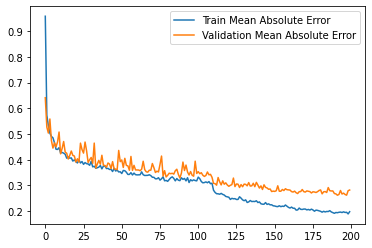

In [ ]:
# change the aggr function and understand how your model is doing
aggr = "add"  # max, mean, add

best_model_path = f"Directional_MPNN_{aggr}.pth"
n_epochs = 200

# Data
train_dataset.transform = get_directional_F
val_dataset.transform = get_directional_F
test_dataset.transform = get_directional_F

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Directional_MPNN_model(21, edge_net(3, 128), aggr)
model = model.to(device)

# Optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min",
                                                       factor=0.5, patience=20,
                                                       verbose=True)

# Training
history = train(model, train_loader, val_loader, optimizer, scheduler, n_epochs, best_model_path)

# Display results
plt.plot(history["train_mae"], label="Train Mean Absolute Error")
plt.plot(history["val_mae"], label="Validation Mean Absolute Error")
plt.legend()
plt.show()

In [ ]:
# Evaluation
aggr = "add"  # max, mean, add
best_model_path = f"Directional_MPNN_{aggr}.pth"
model = Directional_MPNN_model(21, edge_net(3, 128), aggr)
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)
test_mae = test(model, test_loader)
print("Test Mean Absolute Error", test_mae)

Test Mean Absolute Error 0.2711749670505524
